In [17]:
from datetime import date
from functools import reduce
import pandas as pd
import covidcast
import requests

*Some preprocessing to get state population data before exploring our main datasets*

In [73]:
#our main dataset refers to U.S states as their postal code (e.g ny, ca), so we must convertt all other datasets to conform to this
stateNamesToPostalCodeMapping = {
    "Alabama": "al",
    "Alaska": "ak",
    "Arizona": "az",
    "Arkansas": "ar",
    "California": "ca",
    "Colorado": "co",
    "Connecticut": "ct",
    "Delaware": "de",
    "District of Columbia": "dc",
    "Florida": "fl",
    "Georgia": "ga",
    "Hawaii": "hi",
    "Idaho": "id",
    "Illinois": "il",
    "Indiana": "in",
    "Iowa": "ia",
    "Kansas": "ks",
    "Kentucky": "ky",
    "Louisiana": "la",
    "Maine": "me",
    "Maryland": "md",
    "Massachusetts": "ma",
    "Michigan": "mi",
    "Minnesota": "mn",
    "Mississippi": "ms",
    "Montana": "mt",
    "Missouri": "mo",
    "Nebraska": "ne",
    "Nevada": "nv",
    "New Hampshire": "nh",
    "New Jersey": "nj",
    "New Mexico": "nm",
    "New York": "ny",
    "North Carolina": "nc",
    "North Dakota": "nd",
    "Ohio": "oh",
    "Oklahoma": "ok",
    "Oregon": "or",
    "Pennsylvania": "pa",
    "Rhode Island": "ri",
    "South Carolina": "sc",
    "South Dakota": "sd",
    "Tennessee": "tn",
    "Texas": "tx",
    "Utah": "ut",
    "Vermont": "vt",
    "Virginia": "va",
    "Washington": "wa",
    "West Virginia": "wv",
    "Wisconsin": "wi",
    "Wyoming": "wy",
    "Puerto Rico": "pr"
}

In [76]:
#get each states population
statePop = {} 
for state in requests.get("https://datausa.io/api/data?drilldowns=State&measures=Population&year=latest").json()["data"]: 
    state["State"] = stateNamesToPostalCodeMapping[state["State"]] #convert state name from name to postal code (e.g New York -> ny)
    statePop[state["State"]] = state["Population"]

### How does the percentage of people wearing masks compare with the percentage of the population infected with new cases of COVID-19 in each U.S state for the latest recorded month (Nov 2020) ?

In [79]:
maskdf = covidcast.signal("fb-survey", "smoothed_wearing_mask", date(2020, 11, 2), date(2020, 12,2), "state")

In [80]:
casesdf = covidcast.signal("jhu-csse", "confirmed_7dav_incidence_num", date(2020, 11, 2), date(2020, 12, 2), "state")

In [81]:
stateStats = {}

In [82]:
def getAvgValueFromPeriod(dailyValuesFromPeriod: list, numDaysInPeriod: int) -> float:
    return reduce(lambda x,y: x+y, dailyValuesFromPeriod) / numDaysInPeriod

In [100]:
for state in maskdf["geo_value"].unique().tolist():
    avgPercentDailyMaskWearers = getAvgValueFromPeriod(maskdf[maskdf["geo_value"] == state]["value"].tolist(), 31),#TODO: why is this resulting in a tuple in the final result ?
    totalNumNewCases = reduce(lambda x,y: x+y, casesdf[casesdf["geo_value"] == state]["value"].tolist())
    percentInfected = (totalNumNewCases / statePop[state]) * 100
    stateStats[state] = [avgPercentDailyMaskWearers[0], percentInfected]

In [102]:
df = pd.DataFrame.from_dict(stateStats, orient="index", columns=["%Masked", "%Infected"])

In [103]:
df.sort_values(by="%Masked", inplace=True) #get from least % of masks worn to highest

In [104]:
df

,%Masked,%Infected
wy,74.862982,3.475803
sd,78.534986,4.030332
id,79.839691,2.165267
la,82.048669,1.008570
ok,82.498069,1.874260
ga,83.261736,1.079776
ms,83.819595,1.116743
al,84.171330,1.181376
mo,84.592830,2.000622
nd,84.708056,4.876555


In [106]:
"""
In order to graph this, we want to remove the state identifier for now 
and just focus on the mask % vs avg # of daily cases. Do this by setting the index.
"""
df.set_index('%Masked', inplace=True) 

We can now use this data to make a graph in which the x-axis is percentages of people wearing masks, and the y axis is the number of cases. We can use this type of graph to show that as the percentage of mask wearers increases, the number of cases decreases. 

Text(0.5, 1.0, '% of people wearing masks vs % of people infected')

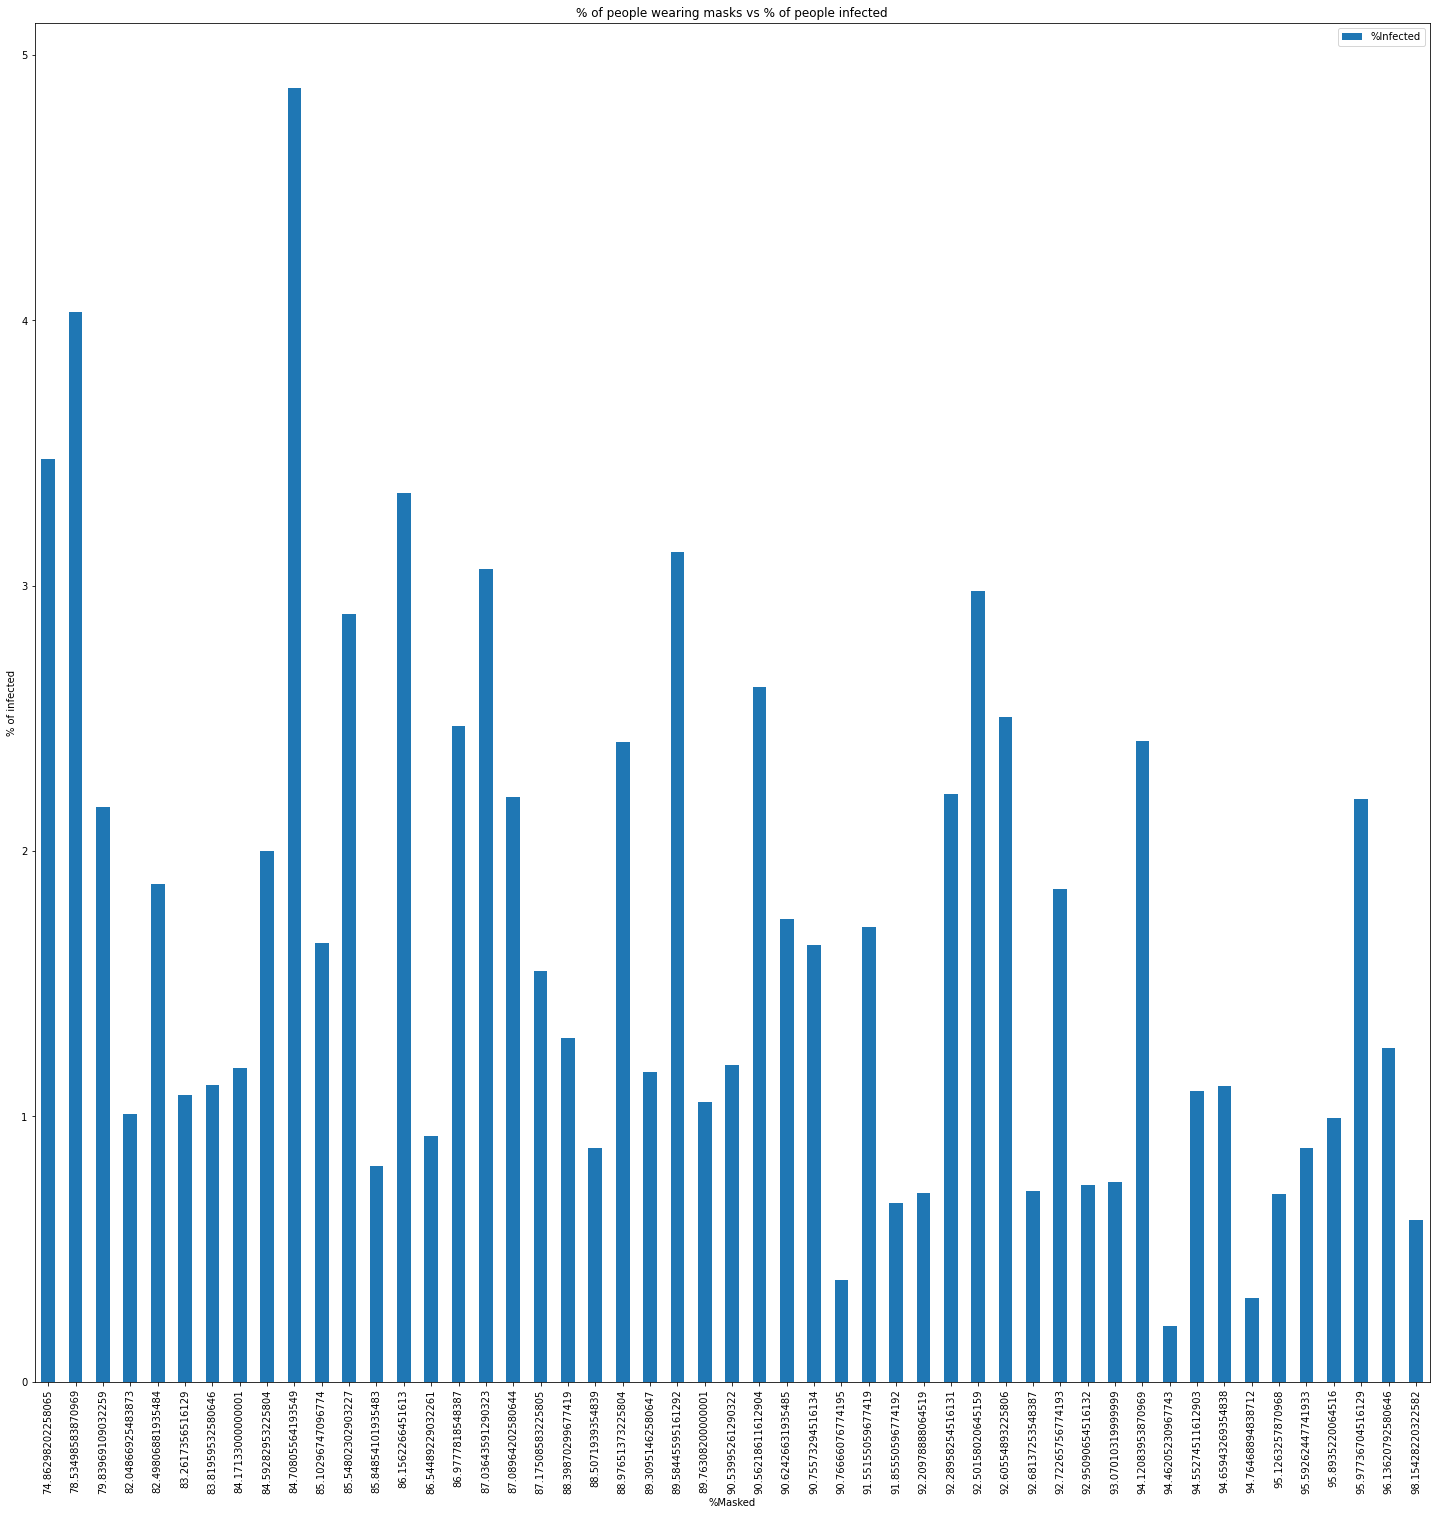

In [108]:
graph = df.plot(kind="bar", figsize=(25,25))
graph.set_ylabel("% of infected")
graph.set_title("% of people wearing masks vs % of people infected")

As you can see, there are more peaks representing higher infection rates on the left side of the graph than on the right side, signifying that as the percentage of individuals in a population wearing masks increases, the % of new infected individuals of the total population decreases. 

*Todo: Overlay a line here to illustrate negative correlation?*